In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import cv2
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
model = keras.models.load_model('keras-facenet-master/keras-facenet-master/model/keras/model/facenet_keras.h5')
model.load_weights('keras-facenet-master/keras-facenet-master/model/keras/weights/facenet_keras_weights.h5')
for layer in model.layers:
    layer.trainable = False
model.summary()

C:\Users\arsal\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\layers\core.py:1059: UserWarning: inception_resnet_v1 is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

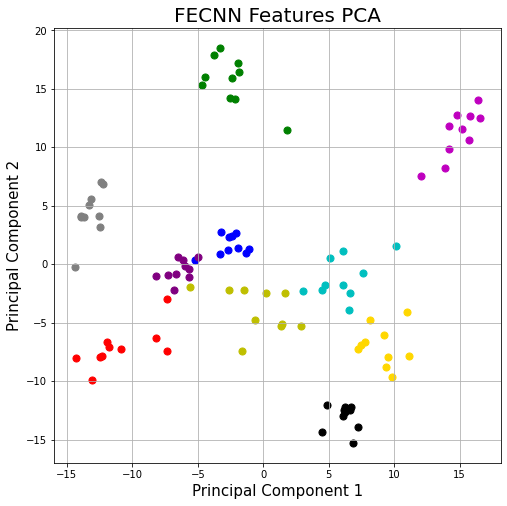

In [3]:
x = []
y = 0
for filename in os.listdir('final_gen_data_209/train'):
    if y == 100:
        break
    img = cv2.imread(os.path.join('final_gen_data_209/train',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img - mean) / std
    img = np.array([img])
    img = tf.convert_to_tensor(img)
    vec = model.predict(img)
    x.append(vec.flatten())
    y += 1

#PCA to reduce 512D vectors to 2D
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

#Plotting the PCA
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FECNN Features PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
x = 10
for i in range(10):
    ax.scatter(principalDf.loc[range((i*x),((i*x)+x)), 'principal component 1']
               , principalDf.loc[range((i*x),((i*x)+x)), 'principal component 2']
               , c = colors[i]
               , s = 50)
ax.grid()

In [4]:
i=0
train_data = np.zeros((2090,512))
train_labels = np.zeros((2090,))
for filename in os.listdir('final_gen_data_209/train'):
    hr = cv2.imread(os.path.join('final_gen_data_209/train',filename))
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    
    hr = hr.astype('float32')
    mean, std = hr.mean(), hr.std()
    hr = (hr - mean) / std
    
    hr = np.array([hr])
    hr = tf.convert_to_tensor(hr)
    vec = model.predict(hr)
    vec = vec.flatten()
    train_data[i] = vec
    train_labels[i] = int(i/10)
    i += 1

In [5]:
#STANDARDIZATION

mean_arr = []
std_arr = []
for i in range(len(train_data[0])):
    x = train_data[:,i]
    x = x.astype('float32')
    mean, std = x.mean(), x.std()
    x = (x - mean) / std
    mean_arr.append(mean)
    std_arr.append(std)
    train_data[:,i] = x

In [6]:
i=0
test_data = np.zeros((627,512))
test_labels = np.zeros((627,))
for filename in os.listdir('final_gen_data_209/test'):
    lr = cv2.imread(os.path.join('final_gen_data_209/test',filename))
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    
    lr = lr.astype('float32')
    mean, std = lr.mean(), lr.std()
    lr = (lr - mean) / std
    
    lr = np.array([lr])
    lr = tf.convert_to_tensor(lr)
    vec1 = model.predict(lr)
    vec1 = vec1.flatten() 
    test_data[i] = vec1
    test_labels[i] = int(i/3)
    i += 1

In [7]:
#STANDARDIZATION

for i in range(len(test_data[0])):
    x = test_data[:,i]
    x = x.astype('float32')
    x = (x - mean_arr[i]) / std_arr[i]
    test_data[:,i] = x

In [8]:
svc_model = svm.SVC(kernel = 'linear', gamma='scale', probability = True) 
svc_model.fit(train_data, train_labels)

## Train Accuracy
pred = svc_model.predict(train_data)
train_acc = accuracy_score(train_labels, pred)
print("Training Accuracy: ", train_acc)

## Test Accuracy
pred = svc_model.predict(test_data)
test_acc = accuracy_score(test_labels, pred)
print("Test Accuracy: ", test_acc)

Training Accuracy:  1.0
Test Accuracy:  1.0
